In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import naive_bayes
from sklearn import svm


import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None


import pickle
import df_trimmer


In [3]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
df.shape

(24150, 91)

# function for testing

In [34]:
def model_trainer(model_function, X, y):
    '''
    
    Fits a model to a dataframe's features and target values.
    
    Splits the data into train test values, then splits training
    with a stratified k_fold to account for class imbalance, 
    which is approx. 1-recidivist: 2-non-recidivist. 
    
    In k-fold, oversamples to even out class imbalance.
    
    Returns a mean roc_auc_score, which is the average
    of the roc_auc_scores of the k-fold validation sets.
    
    Parameters
    -------
    model_function = model to perform the fit with.  
    Include whichever hyperparamters deemed necessary.
    
    X = The features of the data set. 
    y = the target values of the data set. 
    X and y must be of the same length.
    
    
    '''
    roc_auc_list = []
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2, random_state=42)

    kf = StratifiedKFold(n_splits=5, random_state=42)

    for train_ind, val_ind in kf.split(X_train, y_train):

        X_ktrain, X_kval = X.iloc[train_ind], X.iloc[val_ind]
        y_ktrain, y_kval = y.iloc[train_ind], y.iloc[val_ind]

        ros = RandomOverSampler(random_state=42)
        X_train_resampled, y_train_resampled = ros.fit_resample(X_ktrain, y_ktrain)

        reg = model_function
        reg.fit(X_train_resampled,y_train_resampled)
        y_pred = reg.predict_proba(X_kval)[:,1]
        score = roc_auc_score(y_kval, y_pred)

        roc_auc_list.append(score)

    mean_roc_auc = sum(roc_auc_list)/len(roc_auc_list)

    #print(sum(roc_auc_list)/len(roc_auc_list))
    return mean_roc_auc

# Logistic

In order to make the results more interpretable, I defined the df_trimmer function in an external .py file.  The methods in df_trimmer creates sub-dataframes.  For eample, teh df_conv_subt method includes only conviction subtype, filtering out the broader categories of conviction class and type. 

The no_years_no_target method performed consistently well. The no_years_no_target method filters out all 'year_released' and 'reporting_year' fields, as well as the target population field. The target population field represents a choice by the designers of the original study to focus on certain released ex-offenders.

The logistic model ended up performing the best out of all the  models. Below, I will cycle through the various subsets of data prepared by the df_trimmer function.  

In [7]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df[mask]
df_dict = {'all_features':df_trimmer.all_features(df),
           'no_targ_pop':df_trimmer.no_targ_pop(df),
           'no_years':df_trimmer.no_years(df), 
           'no_years_no_target': df_trimmer.no_years_no_target(df),
           'subtype':df_trimmer.conv_subt(df), 'subtype_no_targ':df_trimmer.subt_no_target(df), 
           'subt_no_tar_no_year':df_trimmer.subt_no_targ_no_years(df),
           'class':df_trimmer.conv_class(df), 'class_no_target':df_trimmer.class_no_target(df),
           'type':df_trimmer.conv_type(df), 'type_no_target':df_trimmer.type_no_target(df)}



In [10]:
roc_auc_list = []
best_mean_roc = {}

for key, value in df_dict.items():
    
    df = value
    X = df[0]
    y = df[1]
    best_mean_roc[key] = model_trainer(LogisticRegression(), X, y)

In [11]:
best_mean_roc

{'all_features': 0.6259167683387536,
 'no_targ_pop': 0.6248704534789425,
 'no_years': 0.6379582801257285,
 'no_years_no_target': 0.6443278160165826,
 'subtype': 0.6002769169748345,
 'subtype_no_targ': 0.5725938557208643,
 'subt_no_tar_no_year': 0.5933486277198468,
 'class': 0.6018820260385105,
 'class_no_target': 0.5739736503552244,
 'type': 0.6059579542159873,
 'type_no_target': 0.5865689904118204}

### with no years no target

The no years, no target subset performed the best.  
Below, I will find the best C value for the subset.

In [14]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df[mask]

df = df_trimmer.no_years_no_target(df)
X = df[0]
y = df[1]

# C_range = np.linspace(1,20,50)
C_range = np.linspace(1,2,20)
best_C = 0
best_roc = 0
for C in C_range:
    model_roc = model_trainer(LogisticRegression(C=C), X, y)
    if model_roc > best_roc:
        best_C = C
        best_roc = model_roc


In [13]:
print(best_C, best_roc)

1.2105263157894737 0.644342671034164


# Knn

KNN does not perform as well as logistic.

In [11]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df[mask]
df_dict = {'all_features':df_trimmer.all_features(df),
           'no_targ_pop':df_trimmer.no_targ_pop(df),
           'no_years':df_trimmer.no_years(df), 
           'no_years_no_target': df_trimmer.no_years_no_target(df),
           'subtype':df_trimmer.conv_subt(df), 'subtype_no_targ':df_trimmer.subt_no_target(df), 
           'subt_no_tar_no_year':df_trimmer.subt_no_targ_no_years(df),
           'class':df_trimmer.conv_class(df), 'class_no_target':df_trimmer.class_no_target(df),
           'type':df_trimmer.conv_type(df), 'type_no_target':df_trimmer.type_no_target(df)}
best_mean_roc_auc = {}
roc_auc_list = []

In [15]:
best_mean_roc = {}

for key, value in df_dict.items():
    
    df = value
    X = df[0]
    y = df[1]
    best_mean_roc[key] = model_trainer(KNeighborsClassifier(), X, y)

In [16]:
print(best_mean_roc)

{'all_features': 0.5354161341668107, 'no_targ_pop': 0.5284160872234279, 'no_years': 0.5522638525262046, 'no_years_no_target': 0.5561281759461746, 'subtype': 0.5294825870060366, 'subtype_no_targ': 0.5283930533722117, 'subt_no_tar_no_year': 0.5331259389853924, 'class': 0.5410128334160916, 'class_no_target': 0.5321189301405483, 'type': 0.539497805602971, 'type_no_target': 0.5377030937025655}


In [14]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df[mask]

df = df_trimmer.no_years_no_target(df)
X = df[0]
y = df[1]

# C_range = np.linspace(1,20,50)
K_range = np.linspace(2,12,10)
best_K = 0
best_roc = 0
for K in range(12,16):
    model_roc = model_trainer(KNeighborsClassifier(n_neighbors=K), X, y)
    if model_roc > best_roc:
        best_K = K
        best_roc = model_roc
    print(K)
print(best_K, best_roc)

0.5691029524588626
12
0.5718331510788159
13
0.5732292842549969
14
0.5755092751995405
15
15 0.5755092751995405


# Naive-Bayes Bernouli

In [24]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df[mask]
df_dict = {'all_features':df_trimmer.all_features(df),
           'no_targ_pop':df_trimmer.no_targ_pop(df),
           'no_years':df_trimmer.no_years(df), 
           'no_years_no_target': df_trimmer.no_years_no_target(df),
           'subtype':df_trimmer.conv_subt(df), 'subtype_no_targ':df_trimmer.subt_no_target(df), 
           'subt_no_tar_no_year':df_trimmer.subt_no_targ_no_years(df),
           'class':df_trimmer.conv_class(df), 'class_no_target':df_trimmer.class_no_target(df),
           'type':df_trimmer.conv_type(df), 'type_no_target':df_trimmer.type_no_target(df)}
best_mean_roc_auc = {}
roc_auc_list = []

In [26]:
best_mean_roc = {}

for key, value in df_dict.items():
    
    df = value
    X = df[0]
    y = df[1]

    best_mean_roc[key] = model_trainer(naive_bayes.BernoulliNB(), X, y)

In [27]:
print(best_mean_roc)

{'all_features': 0.6056066876918941, 'no_targ_pop': 0.605280110219917, 'no_years': 0.6254983141718499, 'no_years_no_target': 0.6266309993864152, 'subtype': 0.5933795318582685, 'subtype_no_targ': 0.5699823964756435, 'subt_no_tar_no_year': 0.5917707345050085, 'class': 0.5988526098424409, 'class_no_target': 0.5724899123976942, 'type': 0.60524009066357, 'type_no_target': 0.5854191628758054}


In [45]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df[mask]
df=df_trimmer.no_years_no_target(df)
X = df[0]
y = df[1]


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 42)
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

reg = naive_bayes.BernoulliNB()
reg.fit(X_train_resampled,y_train_resampled)
y_pred = reg.predict_proba(X_test)[:,1]
score = roc_auc_score(y_test, y_pred)
nb_fpr, nb_tpr, nb_roc = roc_curve(y_test, y_pred)

In [30]:
score

0.6463419356947212

# Random Forest

In [35]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df[mask]
df_dict = {'all_features':df_trimmer.all_features(df),
           'no_targ_pop':df_trimmer.no_targ_pop(df),
           'no_years':df_trimmer.no_years(df), 
           'no_years_no_target': df_trimmer.no_years_no_target(df),
           'subtype':df_trimmer.conv_subt(df), 'subtype_no_targ':df_trimmer.subt_no_target(df), 
           'subt_no_tar_no_year':df_trimmer.subt_no_targ_no_years(df),
           'class':df_trimmer.conv_class(df), 'class_no_target':df_trimmer.class_no_target(df),
           'type':df_trimmer.conv_type(df), 'type_no_target':df_trimmer.type_no_target(df)}
best_mean_roc_auc = {}
roc_auc_list = []

In [36]:
best_mean_roc = {}
for depth in range(2,10):
    for key, value in df_dict.items():

        df = value
        X = df[0]
        y = df[1]
        dict_str = str(key)+str(depth)
        best_mean_roc[dict_str] = [model_trainer(RandomForestClassifier(max_depth=depth), X, y)]

In [37]:
print(best_mean_roc)

{'all_features2': [0.590052625969259], 'no_targ_pop2': [0.6076203151992854], 'no_years2': [0.5932733170533409], 'no_years_no_target2': [0.6022299583190814], 'subtype2': [0.5818420450180349], 'subtype_no_targ2': [0.5477735429741979], 'subt_no_tar_no_year2': [0.5751314590213719], 'class2': [0.5922672762601497], 'class_no_target2': [0.5652404839218295], 'type2': [0.5987392068498076], 'type_no_target2': [0.5772395520593357], 'all_features3': [0.6071386924917319], 'no_targ_pop3': [0.6069780287918104], 'no_years3': [0.6140716350509863], 'no_years_no_target3': [0.6127486472954817], 'subtype3': [0.5898146938612122], 'subtype_no_targ3': [0.5724180554076288], 'subt_no_tar_no_year3': [0.5852231386065107], 'class3': [0.599985178436018], 'class_no_target3': [0.5689055457923493], 'type3': [0.6016980157157116], 'type_no_target3': [0.5824018154682735], 'all_features4': [0.6057853245721597], 'no_targ_pop4': [0.6141693270466373], 'no_years4': [0.6108467041610511], 'no_years_no_target4': [0.6133805938595

In [38]:
max_rf = 0
max_dep_comb = 0
for key, value in best_mean_roc.items():
    if best_mean_roc[key][0] > max_rf:
        max_rf = value
        max_dep_comb = key
print(max_rf, max_dep_comb)

[0.6260309805442391] no_years_no_target8


## Random Forest run with best depth

In [39]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df[mask]
df = df_trimmer.no_years(df)
X = df[0]
y = df[1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2, random_state=42)

In [40]:
rf = RandomForestClassifier(max_depth=7)
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
rf.fit(X_train_resampled, y_train_resampled)
y_pred = rf.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.6484903378106115

In [41]:
#Create variables for roc curve.
rf_fpr, rf_tpr, rf_log_roc = roc_curve(y_test, y_pred)

## Random Forest Feature Importances

In [27]:
import operator

df_feature_imp = {}

for imp, feature in (zip(rf.feature_importances_, list(X))):
    df_feature_imp[feature] = imp

sorted_features = sorted(df_feature_imp.items(), key=operator.itemgetter(1)) 
sorted_features

[('conviction_subtype_Sex Offender Registry/Residency',
  0.00013468923820442327),
 ('release_type_Paroled to Detainer - U.S. Marshall', 0.00023590308900794452),
 ('conviction_subtype_Kidnap', 0.00025938102191985),
 ('conviction_subtype_Forgery/Fraud', 0.0002961114358354426),
 ('conviction_subtype_Weapons', 0.00046066519337019287),
 ('conviction_class_Serious Misdemeanor', 0.00047552276000190796),
 ('conviction_subtype_Vandalism', 0.0006452191475147929),
 ('conviction_subtype_Other Drug', 0.0008236482488283139),
 ('conviction_subtype_Arson', 0.0009124459981400795),
 ('conviction_class_Felony - Enhanced', 0.0011218606389911492),
 ('conviction_subtype_Special Sentence Revocation', 0.0011572477255320489),
 ('release_type_Paroled to Detainer - Out of State', 0.0011768737309175684),
 ('release_type_Paroled to Detainer - Iowa', 0.0012416169564737714),
 ('conviction_subtype_Flight/Escape', 0.0012935696944585),
 ('conviction_subtype_Other Violent', 0.0014756770406905888),
 ('conviction_class_S

## Feature Importance Subtype

In [31]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))

In [34]:
#Comment out subtypes which random forest deemed unnecessary.
subtype_list = [ 'conviction_subtype_Alcohol',
# 'conviction_subtype_Animals',
 'conviction_subtype_Arson',
 'conviction_subtype_Assault',
 'conviction_subtype_Burglary',
 'conviction_subtype_Drug Possession',
 'conviction_subtype_Flight/Escape',
 'conviction_subtype_Forgery/Fraud',
 'conviction_subtype_Kidnap',
 'conviction_subtype_Murder/Manslaughter',
 'conviction_subtype_OWI',
 'conviction_subtype_Other Criminal',
 'conviction_subtype_Other Drug',
 'conviction_subtype_Other Public Order',
 'conviction_subtype_Other Violent',
# 'conviction_subtype_Prostitution/Pimping',
 'conviction_subtype_Robbery',
 'conviction_subtype_Sex',
 'conviction_subtype_Sex Offender Registry/Residency',
 'conviction_subtype_Special Sentence Revocation',
# 'conviction_subtype_Stolen Property',
 'conviction_subtype_Theft',
 'conviction_subtype_Traffic',
 'conviction_subtype_Trafficking',
 'conviction_subtype_Vandalism',
 'conviction_subtype_Weapons']

In [38]:
#iterate through feature importances and show which subtypes
#are deemed most important for the splits.
feature_imp_sorted_keys = sorted(df_feature_imp, key=df_feature_imp.get, reverse=True)
for r in feature_imp_sorted_keys:
    if r in subtype_list:
        print(r, df_feature_imp[r])

conviction_subtype_Other Criminal 0.01950885707389986
conviction_subtype_Murder/Manslaughter 0.012365287364140071
conviction_subtype_Burglary 0.008826455256701105
conviction_subtype_OWI 0.006079551903970369
conviction_subtype_Sex 0.004674769249059317
conviction_subtype_Theft 0.004605512261685431
conviction_subtype_Assault 0.0040345507531533
conviction_subtype_Alcohol 0.003970347402709363
conviction_subtype_Drug Possession 0.0034268821582461805
conviction_subtype_Trafficking 0.002906491682672125
conviction_subtype_Robbery 0.002064007669364979
conviction_subtype_Traffic 0.001987041277555113
conviction_subtype_Other Public Order 0.0016330995556206943
conviction_subtype_Other Violent 0.0014756770406905888
conviction_subtype_Flight/Escape 0.0012935696944585
conviction_subtype_Special Sentence Revocation 0.0011572477255320489
conviction_subtype_Arson 0.0009124459981400795
conviction_subtype_Other Drug 0.0008236482488283139
conviction_subtype_Vandalism 0.0006452191475147929
conviction_subtype

## feature importance age

In [39]:
age_features = ['age_at_release_25-34',
 'age_at_release_35-44',
 'age_at_release_45-54',
 'age_at_release_55 and Older',
 'age_at_release_Under 25']

feature_imp_sorted_keys = sorted(df_feature_imp, key=df_feature_imp.get, reverse=True)
for r in feature_imp_sorted_keys:
    if r in age_features:
        print(r, df_feature_imp[r])

age_at_release_55 and Older 0.05261194508574831
age_at_release_45-54 0.019576872520381074
age_at_release_Under 25 0.011796803885261583
age_at_release_35-44 0.008749735309915147
age_at_release_25-34 0.0067681974211375425


## Feature Importance Race

In [40]:
race_features = [ 'race_American Indian or Alaska Native - Non-Hispanic',
 'race_Asian or Pacific Islander - Non-Hispanic',
 'race_Black - Non-Hispanic',
 'race_White - Hispanic',
 'race_White - Non-Hispanic']


feature_imp_sorted_keys = sorted(df_feature_imp, key=df_feature_imp.get, reverse=True)
for r in feature_imp_sorted_keys:
    if r in race_features:
        print(r, df_feature_imp[r])

race_White - Hispanic 0.012748048747849147
race_Black - Non-Hispanic 0.008203246995111758
race_White - Non-Hispanic 0.004162509847231612
race_American Indian or Alaska Native - Non-Hispanic 0.002878817641861118
race_Asian or Pacific Islander - Non-Hispanic 0.001860961107938403


# SVM

In [35]:
def model_trainer_for_svm(model_function, X, y):
    roc_auc_list = []
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2, random_state=42)

    kf = StratifiedKFold(n_splits=5, random_state=42)

    for train_ind, val_ind in kf.split(X_train, y_train):

        X_ktrain, X_kval = X.iloc[train_ind], X.iloc[val_ind]
        y_ktrain, y_kval = y.iloc[train_ind], y.iloc[val_ind]

        ros = RandomOverSampler(random_state=42)
        X_train_resampled, y_train_resampled = ros.fit_resample(X_ktrain, y_ktrain)

        reg = model_function
        reg.fit(X_train_resampled,y_train_resampled)
        y_pred = reg.predict(X_kval)
        score = roc_auc_score(y_kval, y_pred)

        roc_auc_list.append(score)

    mean_roc_auc = sum(roc_auc_list)/len(roc_auc_list)

    #print(sum(roc_auc_list)/len(roc_auc_list))
    print(mean_roc_auc)
    return mean_roc_auc

In [36]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df[mask]
df_dict = {'all_features':df_trimmer.all_features(df),
           'no_targ_pop':df_trimmer.no_targ_pop(df),
           'no_years':df_trimmer.no_years(df), 
           'no_years_no_target': df_trimmer.no_years_no_target(df),
           'subtype':df_trimmer.conv_subt(df), 'subtype_no_targ':df_trimmer.subt_no_target(df), 
           'subt_no_tar_no_year':df_trimmer.subt_no_targ_no_years(df),
           'class':df_trimmer.conv_class(df), 'class_no_target':df_trimmer.class_no_target(df),
           'type':df_trimmer.conv_type(df), 'type_no_target':df_trimmer.type_no_target(df)}
best_mean_roc_auc = {}
roc_auc_list = []

In [37]:
best_mean_roc = {}

df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df_trimmer.no_years_no_target(df)
X = df[0]
y = df[1]
best_mean_roc[key] = model_trainer_for_svm(svm.SVC(kernel='linear'), X, y)

0.5810982612300724


In [38]:
best_mean_roc = {}

df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df_trimmer.no_years_no_target(df)
X = df[0]
y = df[1]
best_mean_roc[key] = model_trainer_for_svm(svm.SVC(kernel='rbf', gamma=.001), X, y)

0.5669331200423507


# Final analysis on logistic model

The logistic model with C=1.211 worked best

In [51]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df[mask]

df = df_trimmer.no_years_no_target(df)
X = df[0]
y = df[1]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2, random_state=42)

In [53]:
mod = LogisticRegression(C=1.2105263157894737)

In [54]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [55]:
mod.fit(X_train_resampled, y_train_resampled)

LogisticRegression(C=1.2105263157894737, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [56]:
y_pred = mod.predict_proba(X_test)[:,1]
y_pred_binary = mod.predict(X_test)
y_pred_binary = pd.DataFrame(y_pred_binary)
roc_auc_score(y_test, y_pred)

0.6688245458696368

## Confusion Matrix

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no_recid', 'recid'],
           yticklabels=['no_recid', 'recid']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

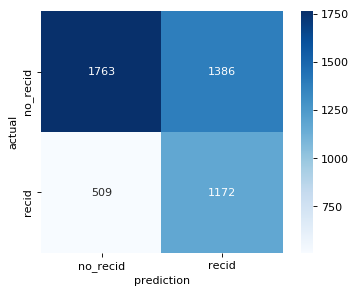

In [58]:
make_confusion_matrix(mod, threshold=.5)

In [59]:
y_pred = mod.predict_proba(X_test)[:,1]
df_pred = pd.DataFrame(y_pred)

In [60]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(mod, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

## ROC curve

In [43]:
fpr, tpr, log_roc = roc_curve(y_test, y_pred)

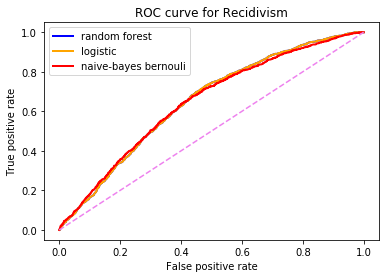

In [47]:
plt.plot(rf_fpr, rf_tpr, lw=2, c='blue')
plt.plot(fpr, tpr, lw=2, c='orange')
plt.plot(nb_fpr, nb_tpr,lw=2, c='red' )
lables = ['random forest', 'logistic', 'naive-bayes bernouli']
plt.legend(lables)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Recidivism')
plt.savefig('Roccurve.svg')

# After modeling analyis

### Assault

In [12]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df[mask]
mask_assault = df[df['conviction_subtype_Assault']==1]
mask_assault['recid_flag'].sum()/len(mask_assault)



0.28096885813148786

### Sex

In [13]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df[mask]
mask_sex = df[df['conviction_subtype_Sex']==1]
mask_sex['recid_flag'].sum()/len(mask_sex)


0.28780934922089824

### Explore Hispanic, over 55, murder

In [21]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df[mask]
at_risk_mask_55 = df[df['age_at_release_55 and Older']==1]
at_risk_mask_55['recid_flag'].sum()/len(at_risk_mask_55)

0.2037037037037037

### 25-34

In [22]:
at_risk_mask_25to34 = df[df['age_at_release_25-34']==1]
at_risk_mask_25to34['recid_flag'].sum()
at_risk_mask_25to34['recid_flag'].sum()/len(at_risk_mask_25to34)

0.37247146570233924

### 45-54

In [23]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df[mask]
mask_45to54 = df[df['age_at_release_45-54']==1]
mask_45to54['recid_flag'].sum()/len(mask_45to54)

0.2932940309506264

### Supervising District None-Discharged

In [24]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df[mask]
none_dis = df[df['supervising_district_None-Discharged']==1]
none_dis['recid_flag'].sum()/len(none_dis)

0.21849606603895266

### Target Population

In [25]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df[mask]
target_pop = df[df['target_pop_flag']==1]
target_pop['recid_flag'].sum()/len(target_pop)

0.39154438471596686

### Supervising District

In [26]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df[mask]
fivejd = df[df['supervising_district_5JD']==1]
fivejd['recid_flag'].sum()/len(fivejd)


0.44969818913480886

In [28]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df[mask]
eos = df[df['release_type_Discharged – End of Sentence']==1]
eos['recid_flag'].sum()/len(eos)


0.24643788882199477

In [29]:
df = pickle.load(open('../data/pickles/df_full.pickle', 'rb'))
mask =[feature  for feature in list(df) if df[feature].sum() > 50]
df = df[mask]
violent = df[df['convicting_type_Violent']==1]
violent['recid_flag'].sum()/len(violent)


0.2708966565349544